In [2]:
import numpy as np
import numpy.random as rnd
import theano
import theano.tensor as T
import lasagne
import time
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def load_mnist_images(filename):
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data

def load_mnist_labels(filename):
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

# We can now download and read the training and test set images and labels.
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [38]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

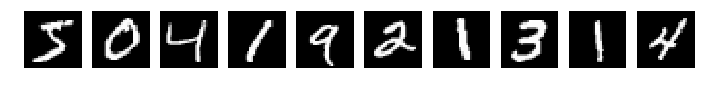

In [39]:
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

In [40]:
X_train = X_train.reshape((60000, 784))
X_test = X_test.reshape((10000, 784))

In [41]:
a = np.zeros((y_train.size, 10))
a[np.arange(y_train.size), y_train] = 1
y_train = a

In [42]:
a = np.zeros((y_test.size, 10))
a[np.arange(y_test.size), y_test] = 1
y_test = a

In [43]:
y_train.shape

(60000, 10)

In [12]:
NUM_EPOCHS = 100
BATCH_SIZE = 16
GRAD_CLIP = 10
N_HIDDEN = 100
SEQ_LEN = 784
TRAIN_SIZE = 60000
TEST_SIZE = 10000

In [125]:
# numerically stable log-softmax with crossentropy
def logsoftmax(x):
    xdev = x-x.max(1,keepdims=True)
    lsm = xdev - T.log(T.sum(T.exp(xdev),axis=1,keepdims=True))
    return lsm

# cross-entropy
# ys are indices of chars, x is a matrix (? BATCH_SIZE * SEQ_LEN, VOCAB_SIZE)
def lsmCE(x,y):
    print(T.shape(x), T.shape(y))
    return -T.clip(x,-20,0)[T.arange(y.shape[0]), y]

In [13]:
# Технические вещи

# Вспомогательная функция для запаковки результата обучения 
def pack(network, inp, target, train_err, test_err, train_acc, test_acc, train_fn, test_fn):
    return {'network':network,
            'inp':inp,
            'target':target,
            
            'train_err':train_err,
            'test_err':test_err,
            'train_acc':train_acc, 
            'test_acc':test_acc, 
            'train_fn':train_fn, 
            'test_fn':test_fn
            } 

In [18]:
def init_posdef_w(n):
    # A = 1/N R^T * R, wehere R is standard normal
    # A is positive definite
    # W = (A + I) / max(spec(A + I))
    # spec(W) = {1, l_i < 1}
    
    R = np.random.normal(size=(n, n))
    A = 1 / N_HIDDEN * np.dot(R.T, R)
    eig, _ = np.linalg.eig(A + np.eye(n))
    e = max(eig)
    W = (A + np.eye(n)) / e
    return W

In [59]:
def build_network_np(inp, num_epochs=NUM_EPOCHS):
    # Network from paper "Improving performance of RNN with ReLU"
    # W_hh is initialized as pos. def. with max eigenvalue 1
    
    l_in = lasagne.layers.InputLayer(shape=(None, SEQ_LEN, 1), input_var=inp)

    alpha = np.sqrt(2) * np.exp(1.2 / (max(N_HIDDEN, 6)))
    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.Normal(std=alpha / N_HIDDEN, mean=0.0),
        W_hid_to_hid=init_posdef_w(N_HIDDEN),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)

    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [60]:
def build_network_identity(inp, num_epochs=NUM_EPOCHS):
    # Network from paper "Simple way to initialize RNN",
    # W_hh is initialized as identity matrix
    l_in = lasagne.layers.InputLayer(shape=(None, SEQ_LEN, 1), input_var=inp)

    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.Normal(1e-3, mean=0.0),
        W_hid_to_hid=np.eye(N_HIDDEN),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [61]:
def build_network_gaus(inp, num_epochs=NUM_EPOCHS):
    # W_hh is initialized from standard normal
    l_in = lasagne.layers.InputLayer(shape=(None, SEQ_LEN, 1), input_var=inp)

    l_rnn = lasagne.layers.RecurrentLayer(
        l_in, N_HIDDEN,
        W_in_to_hid=lasagne.init.GlorotNormal(),
        W_hid_to_hid=lasagne.init.Normal(),
        learn_init=True,
        only_return_final=True,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    l_out = lasagne.layers.DenseLayer(l_rnn, num_units=10,
                                      W=lasagne.init.GlorotNormal(),
                                      nonlinearity=lasagne.nonlinearities.softmax)
    return l_out

In [62]:
# Create a network with particular initialization for parameters
def create_network(build_fn):
    print("Building network ...")
    inp = T.tensor3('input', dtype='float64')
    # Matrix of size BATCH_SIZE * 10 to match network's output
    target_values = T.matrix('target_output', dtype='float64')
    network = build_fn(inp)
    print("The network has {} params".format(lasagne.layers.count_params(network)))
    return (network, inp, target_values)

In [75]:
def train_sgd(network, inp, target_values, Xtrain, ytrain, Xtest, ytest, filename, num_epochs=NUM_EPOCHS):
    num_batches = TRAIN_SIZE // BATCH_SIZE
    train_err=np.zeros(num_epochs)
    train_acc=np.zeros(num_epochs)
    test_err=np.zeros(num_epochs)
    test_acc=np.zeros(num_epochs)
    
    network_output = lasagne.layers.get_output(network)
    cr_ent = T.mean(lasagne.objectives.categorical_crossentropy(network_output, target_values))
    acc_score = lasagne.objectives.categorical_accuracy(
        network_output, target_values).mean(dtype=theano.config.floatX) * 100
    
    # Retrieve all parameters from the network
    all_params = lasagne.layers.get_all_params(network)
    print("Computing updates ...")
    all_grads = T.grad(cr_ent, all_params)
    scaled_grads, grad_norm = lasagne.updates.total_norm_constraint(all_grads, GRAD_CLIP, return_norm=True)
    lr_var = theano.shared(1e-4)
    updates = lasagne.updates.sgd(scaled_grads, all_params, learning_rate=lr_var)

    print("Compiling functions ...")    
    train_fn = theano.function([inp, target_values], [cr_ent, acc_score, grad_norm],
                               updates=updates, allow_input_downcast=True)
    test_fn = theano.function([inp, target_values], [cr_ent, acc_score], allow_input_downcast=True)
    get_output = theano.function([inp], network_output, allow_input_downcast=True)
    
    train_idxs = np.arange(TRAIN_SIZE)
    for epoch in range(num_epochs):
        start_time = time.time()
        if epoch == 33:
            lr_var.set_value(1e-5)
        if epoch == 66:
            lr_var.set_value(1e-6)
        for batch in range(num_batches):
            idx = train_idxs[BATCH_SIZE * batch : BATCH_SIZE * (batch + 1)]            
            err, acc, norm = train_fn(Xtrain[idx, :, np.newaxis], ytrain[idx, :])
            train_err[epoch] += err
            train_acc[epoch] += acc
            
            if batch == num_batches // 4:
                print("25%", end=" ")
            if batch == num_batches // 2:
                print("50%", end=" ")
            if batch == num_batches // 4 * 3:
                print("75%")
            
        train_err[epoch] /= num_batches
        train_acc[epoch] /= num_batches
        
        terr, tacc = test_fn(Xtest[:, :, np.newaxis], ytest)
        test_err[epoch] = terr
        test_acc[epoch] = tacc
        
        print("Epoch {} loss / acc test = {:.4f}, {:.4f} \t"
              "train = {:.4f}, {:.4f} norm = {:.4f} \t time = {:.2f}s".
              format(epoch, test_err[epoch], test_acc[epoch], 
                     train_err[epoch], train_acc[epoch], norm.item(), time.time() - start_time), end="\t")
    
    return pack(network, inp, target_values, train_err, test_err, train_acc, test_acc, train_fn, test_fn)

In [76]:
net, inp, tar = create_network(build_network_np)
nprnn1 = train_sgd(net, inp, tar, X_train, y_train, X_test, y_test, "nprnn1", num_epochs=50)

Building network ...
The network has 11310 params
Computing updates ...
Compiling functions ...
25% 50% 75%
Epoch 0 loss / acc test = 2.3022, 11.3500 	train = 2.3026, 11.1833 norm = 0.3654 	 time = 551.23s	25% 50% 75%
Epoch 1 loss / acc test = 2.3018, 11.3500 	train = 2.3021, 11.2367 norm = 0.3847 	 time = 560.18s	25% 50% 75%
Epoch 2 loss / acc test = 2.3015, 11.3500 	train = 2.3017, 11.2367 norm = 0.3820 	 time = 552.65s	25% 50% 75%
Epoch 3 loss / acc test = 2.3012, 11.3500 	train = 2.3014, 11.2367 norm = 0.4687 	 time = 552.62s	25% 50% 75%
Epoch 4 loss / acc test = 2.3009, 11.3500 	train = 2.3011, 11.2367 norm = 0.6870 	 time = 550.73s	25% 50% 75%
Epoch 5 loss / acc test = 2.3005, 11.3500 	train = 2.3008, 11.2367 norm = 0.6894 	 time = 554.03s	25% 50% 75%
Epoch 6 loss / acc test = 2.2998, 11.3500 	train = 2.3003, 11.2367 norm = 0.9923 	 time = 553.28s	25% 50% 75%
Epoch 7 loss / acc test = 2.2979, 11.3500 	train = 2.2991, 11.2367 norm = 1.6178 	 time = 556.27s	25% 50% 75%
Epoch 8 loss

KeyboardInterrupt: 

In [50]:
X_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])